# Imports

In [1]:
import json
import re
import string

import matplotlib.pyplot as plt
import nltk
import pandas as pd
from nltk.corpus import stopwords
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from tensorflow.python.keras.preprocessing.text import Tokenizer

from library import embedding_for_vocab

# Ensure nltk stopwords are downloaded
try:
    nltk.data.find(resource_name='corpora/stopwords')
except LookupError:
    nltk.download(info_or_id='stopwords')

# Define the regex pattern
RETWEET_PATTERN = r"RT\ \@.*"

# Input and output file names
INPUT_FILE_JSON = "data/X.json"
OUTPUT_FILE_JSON = "data/X.json"
OUTPUT_FILE_CSV = "data/X.csv"
GLOVE_50D_MODEL = "model/glove.6B/glove.6B.50d.txt"

# Define the random state
RANDOM_STATE = 42

K_VALUES = range(2, 11)  # Test cluster sizes from 1 to 10


In [2]:
try:
    # Step 1: Load the JSON file
    with open(file=INPUT_FILE_JSON) as file:
        data = json.load(fp=file)

    # Step 2: Filter entries
    if "entries" in data:
        filtered_entries = [
            entry for entry in data["entries"] if not re.match(pattern=RETWEET_PATTERN, string=entry.get("body", ""))
        ]
        # Update the JSON structure
        data["entries"] = filtered_entries

    # Step 3: Save the result
    with open(file=OUTPUT_FILE_JSON, mode="w") as file:
        json.dump(obj=data, fp=file, indent=4)

    print(f"Cleaned data has been saved to {OUTPUT_FILE_JSON}")
except Exception as e:
    print(f"An error occurred: {e}")


Cleaned data has been saved to data/X.json


In [3]:
try:
    # Step 1: Load the JSON file
    with open(file=INPUT_FILE_JSON) as file:
        data = json.load(fp=file)

    # Step 2: Extract the 'entries' key
    entries = data.get("entries", [])

    # Step 3: Load entries into a DataFrame
    df = pd.DataFrame(data=entries)

    # Step 4: Display or use the DataFrame
    print("DataFrame loaded successfully!")
    display(df.head())  # Display the first few rows

    # Step 5: Save the DataFrame
    df.to_csv(path_or_buf=OUTPUT_FILE_CSV, index=False)
    print(f"DataFrame saved to {OUTPUT_FILE_CSV}")
except Exception as e:
    print(f"An error occurred: {e}")


DataFrame loaded successfully!


,sma_id,post_id,title,body,sourcetype,full_text,language,data_created,created
0,72,1855407258336657712,,I’m also at:\n\nhttps://t.co/ejE8ahOKHX\n\nand...,Twitter,'/6yfgx6srr2':11 '/eje8ahokhx':7 'also':3 'm':...,en,2024-11-10T00:28:56,2024-11-10T00:28:56
1,90,1855405259881123899,,EFF is at its best when the stakes are high. h...,Twitter,'/aspodcbppf':13 'best':5 'eff':1 'high':10 's...,en,2024-11-10T00:21:00,2024-11-10T00:21:00
2,86,1855401615685009538,,@mediaphyter @DrStacyThayer This picture made ...,Twitter,'amazing':9 'drstacythayer':2 'made':5 'mediap...,en,2024-11-10T00:06:31,2024-11-10T00:06:31
3,90,1855366756031725721,,"Today at 2pm PT, @aaronswartzday will celebrat...",Twitter,'/mixvd7f8ca':32 '2pm':3 'aaronswartzday':5 'a...,en,2024-11-09T21:48:00,2024-11-09T21:48:00
4,78,1855359051019993197,,"@Cyb3rMonk Oh gods, moving averages in Vendor ...",Twitter,'averages':5 'changed':9 'cyb3rmonk':1 'gods':...,en,2024-11-09T21:17:23,2024-11-09T21:17:23


DataFrame saved to data/X.csv


> Perform Topic Clustering


In [4]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text


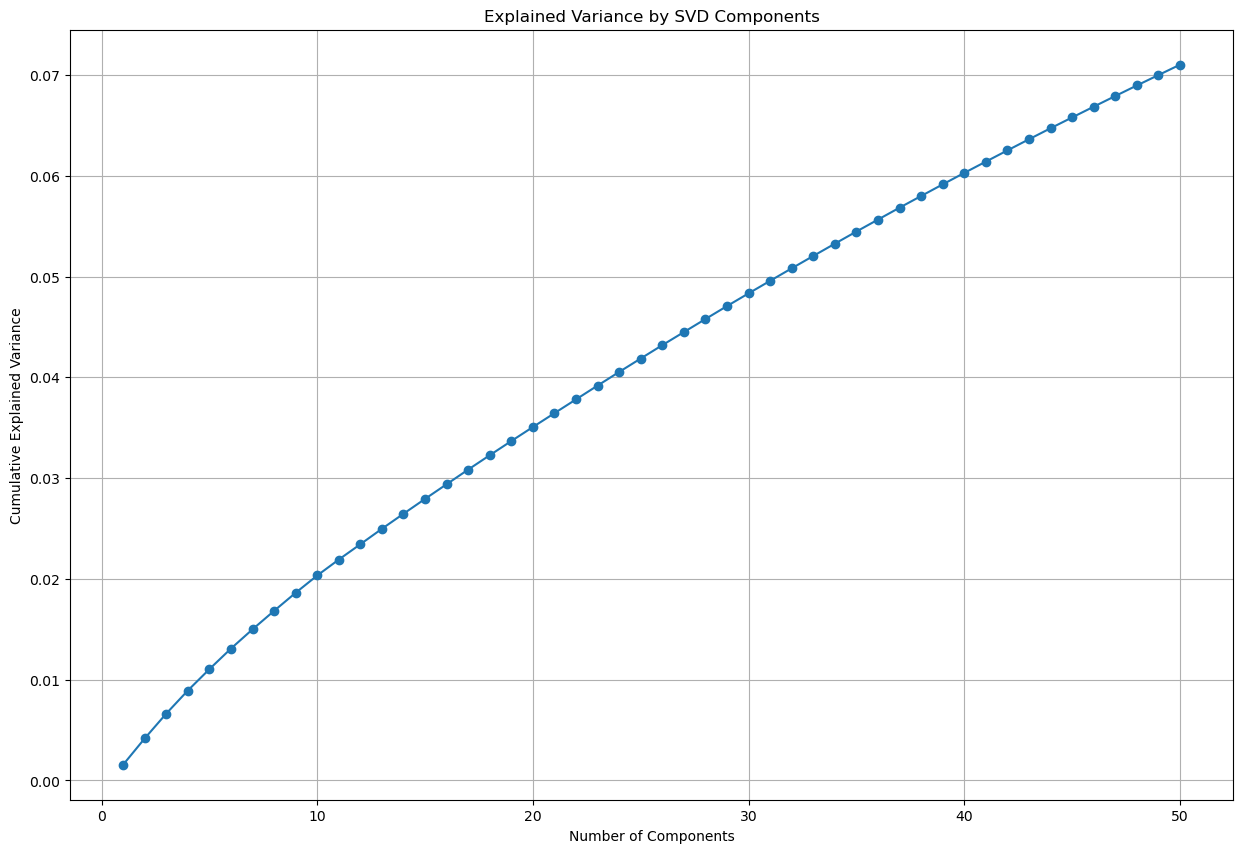

In [5]:
# Define stopwords
stop_words = set(stopwords.words("english"))

# Step 1: Preprocess the text
# Apply preprocessing to the 'body' column
df['body_cleaned'] = df['body'].apply(func=preprocess_text)

# Step 2: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(raw_documents=df['body_cleaned'])

# Step 3: Dimensionality Reduction with SVD
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
reduced_matrix = svd.fit_transform(X=tfidf_matrix)

# Step 4: Compute explained variance for the SVD components
explained_variance = svd.explained_variance_ratio_.cumsum()

# Plot Explained Variance
plt.figure(figsize=(15, 10))
plt.plot(range(1, n_components + 1), explained_variance, marker='o')
plt.title("Explained Variance by SVD Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()


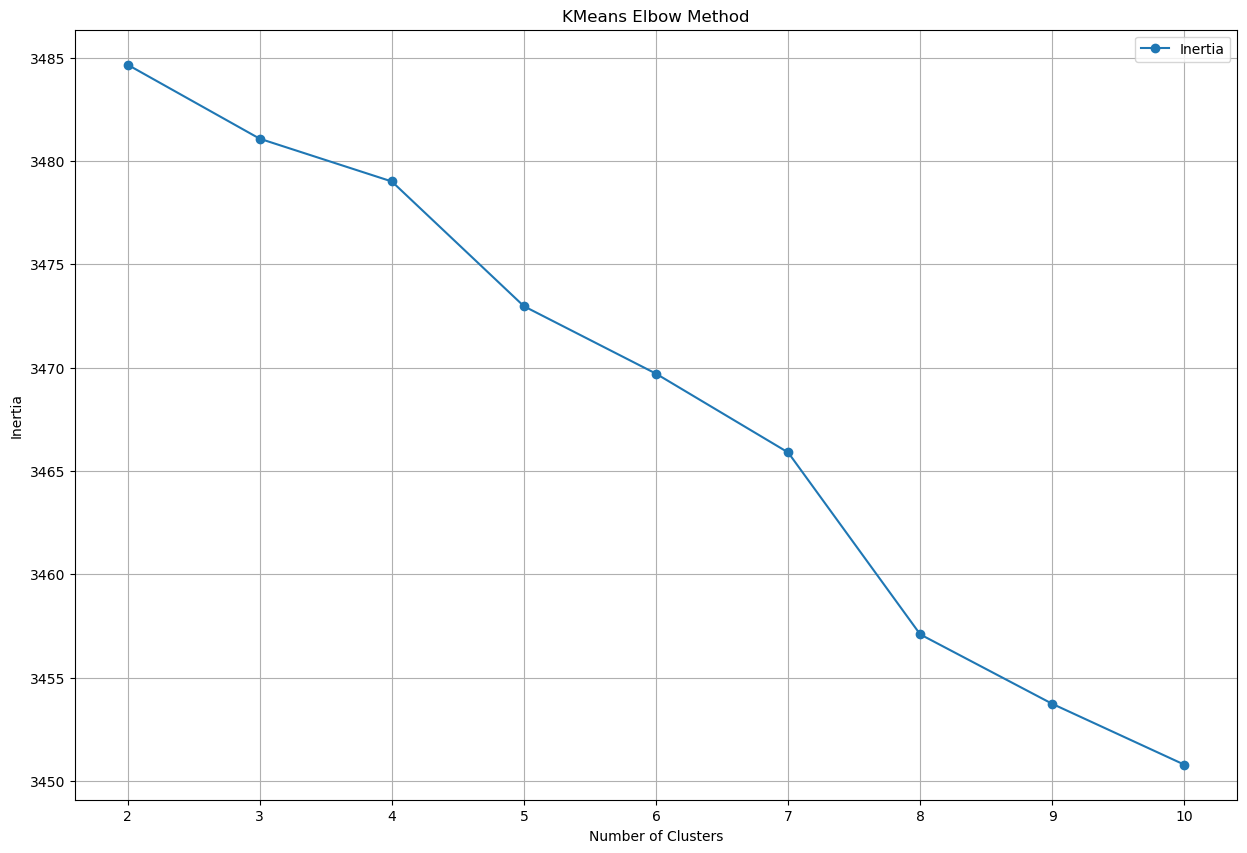

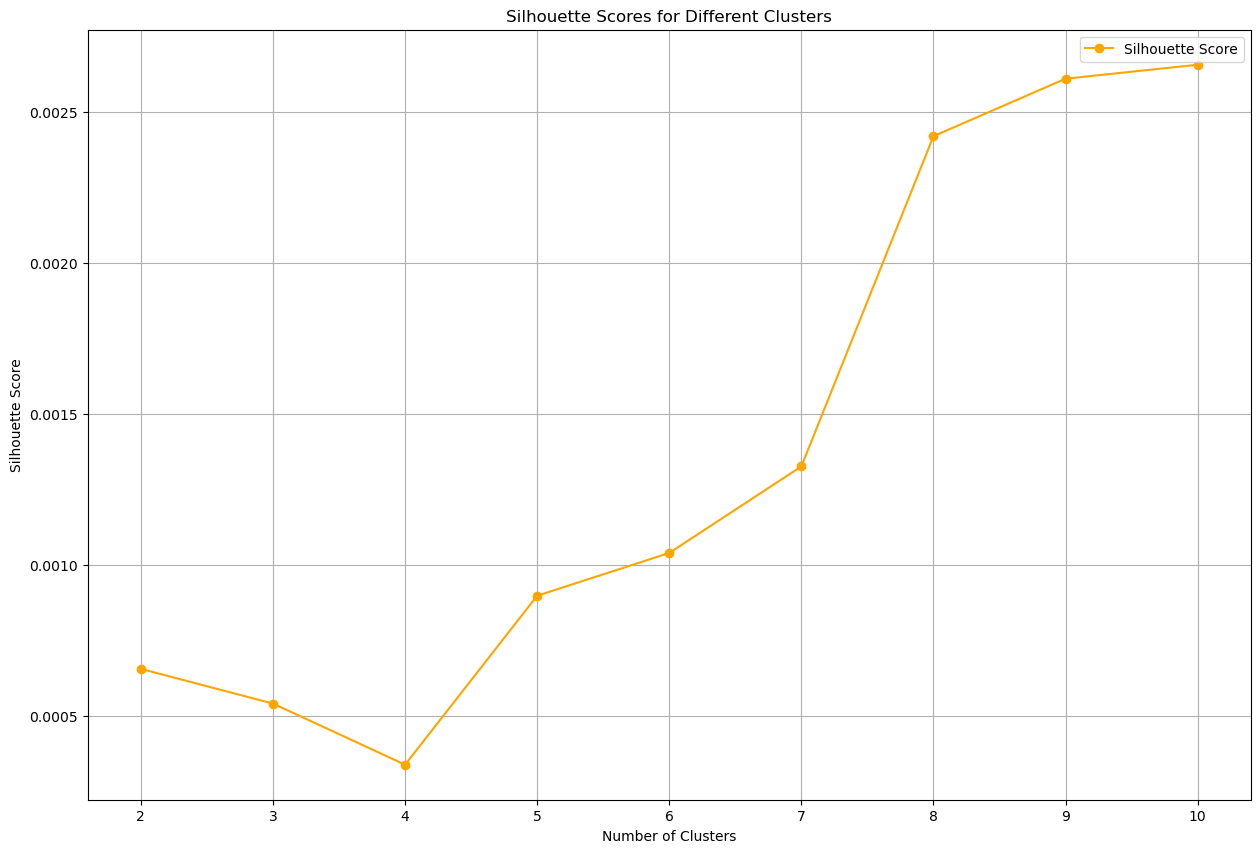

In [6]:
# Step 5: Apply KMeans Clustering
inertia = []
sil_scores = []

for k in K_VALUES:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE)
    kmeans.fit(X=tfidf_matrix)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X=tfidf_matrix, labels=kmeans.labels_))

# Plot Elbow Curve
plt.figure(figsize=(15, 10))
plt.plot(K_VALUES, inertia, marker='o', label='Inertia')
plt.title("KMeans Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.legend()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(15, 10))
plt.plot(K_VALUES, sil_scores, marker='o', color='orange', label='Silhouette Score')
plt.title("Silhouette Scores for Different Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.legend()
plt.show()


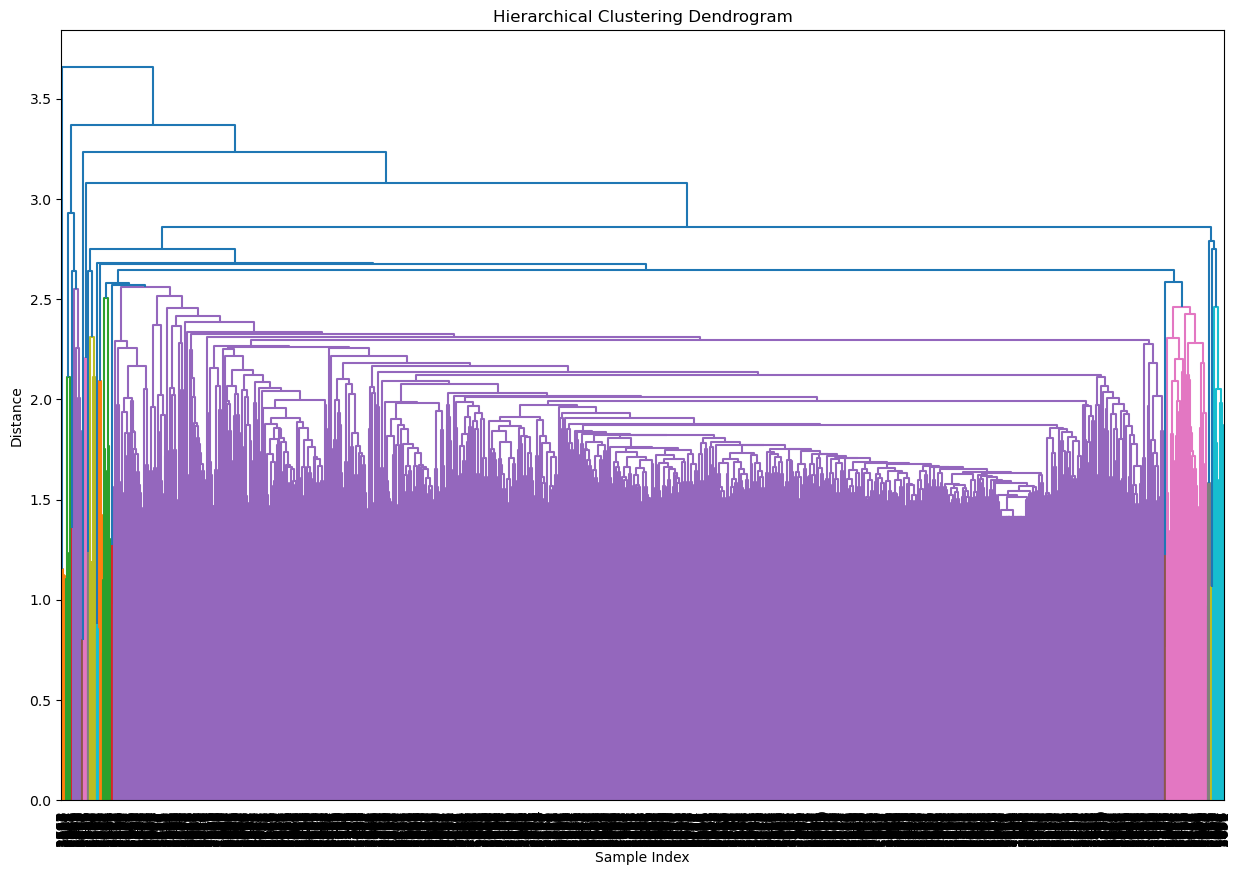

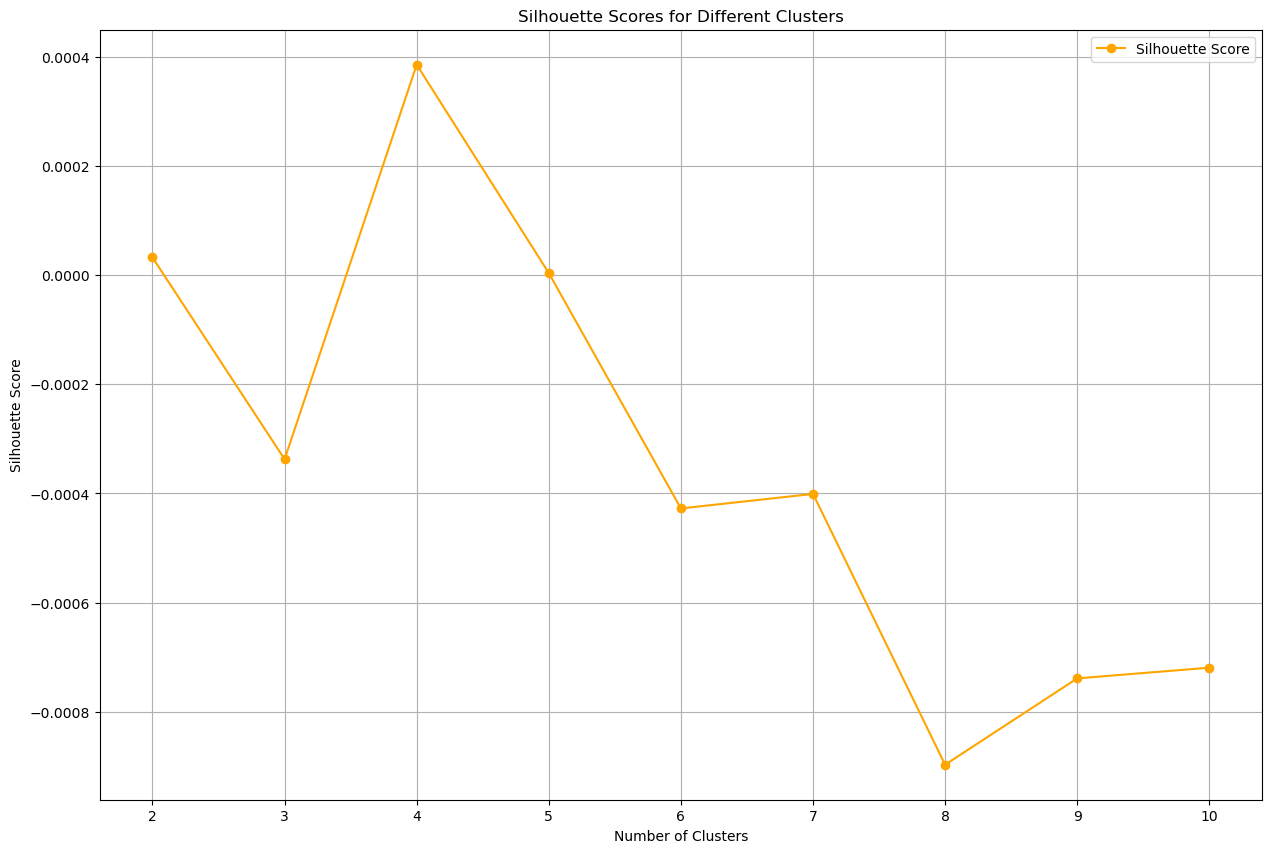

In [7]:
# Step 5: Apply Hierarchical Clustering
linkage_matrix = linkage(y=tfidf_matrix.todense(), method="ward")  # 'ward' minimizes variance within clusters

# Step 6: Visualize with Dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z=linkage_matrix, leaf_font_size=10, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Step 7: Determine and Assign Clusters
# Decide on the number of clusters or a distance threshold
sil_scores = []

for k in K_VALUES:
    cluster_labels = fcluster(Z=linkage_matrix, t=k, criterion="maxclust")
    sil_scores.append(silhouette_score(X=tfidf_matrix, labels=cluster_labels))

# Plot Silhouette Scores
plt.figure(figsize=(15, 10))
plt.plot(K_VALUES, sil_scores, marker='o', color='orange', label='Silhouette Score')
plt.title("Silhouette Scores for Different Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.legend()
plt.show()


In [ ]:
stop_words = set(stopwords.words("english"))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['full_text'])

# Step 1: Load GloVe embeddings
embedding_matrix_vocab = embedding_for_vocab(
    filepath=GLOVE_50D_MODEL,
    word_index=tokenizer.word_index,
    embedding_dim=50
)

# Step 2: Preprocess Text
